# Object detection with SSD

**Code provenance**
- This code is from the TF2 course of Lazy Programmer (SSD section):
https://www.udemy.com/course/advanced-computer-vision

**Pretrained model used**
- Instead of ResNet101 pretrained model as in the original notebook, we will use EfficientNet  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz

- The list of pretrained models available for the application of object detection is:
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

**Dataset used for object detection**
- The dataset used for object detection is 'Data for Yolo v3 kernel'
https://www.kaggle.com/datasets/aruchomu/data-for-yolo-v3-kernel

# Clone TF Repo, install API

In [2]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 93478, done.
remote: Counting objects: 100% (3367/3367), done.
remote: Compressing objects: 100% (1891/1891), done.
remote: Total 93478 (delta 1622), reused 3123 (delta 1450), pack-reused 90111
Receiving objects: 100% (93478/93478), 617.28 MiB | 14.27 MiB/s, done.
Resolving deltas: 100% (66560/66560), done.


In [3]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

In [4]:
!cd models/research/ && cp object_detection/packages/tf2/setup.py . && \
python -m pip install .

Processing /kaggle/working/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 52.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 48.

# Libraries

In [5]:
import os
import pathlib
import tensorflow as tf
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

2024-03-04 08:51:25.430715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 08:51:25.430832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 08:51:25.576160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Download pretrained model, label file

In [7]:
#PRETRAINED MODEL
url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz'

PATH_TO_MODEL_DIR = tf.keras.utils.get_file(
    fname='efficientdet_d5_coco17_tpu-32',
    origin=url,
    untar=True)

256286417/256286417 [==============================] - 3s 0us/step


In [8]:
PATH_TO_MODEL_DIR

'/root/.keras/datasets/efficientdet_d5_coco17_tpu-32'

In [9]:
#LABEL FILE
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

PATH_TO_LABELS = tf.keras.utils.get_file(
    fname='mscoco_label_map.pbtxt',
    origin=url,
    untar=False)

5056/5056 [==============================] - 0s 0us/step


In [10]:
PATH_TO_LABELS

'/root/.keras/datasets/mscoco_label_map.pbtxt'

In [14]:
!head {PATH_TO_LABELS}

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


# Load model, label file

In [11]:
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 45.17678141593933 seconds


In [13]:
category_index = label_map_util.create_category_index_from_labelmap(
    PATH_TO_LABELS,
    use_display_name=True)
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

# Object detection

In [16]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [15]:
def detect_objects(image_path):
    print('Running inference for {}... '.format(image_path), end='')
    image_np = load_image_into_numpy_array(image_path)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]
    # Do the detection
    detections = detect_fn(input_tensor)
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # show classes
    # unique_classes = set(detections['detection_classes'])
    # print("Classes found:")
    # for c in unique_classes:
    #     print(category_index[c]['name'])

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure(figsize=(15, 10))
    plt.imshow(image_np_with_detections)
    print('Done')
    plt.show()

Running inference for /kaggle/input/data-for-yolo-v3-kernel/dog.jpg... Done


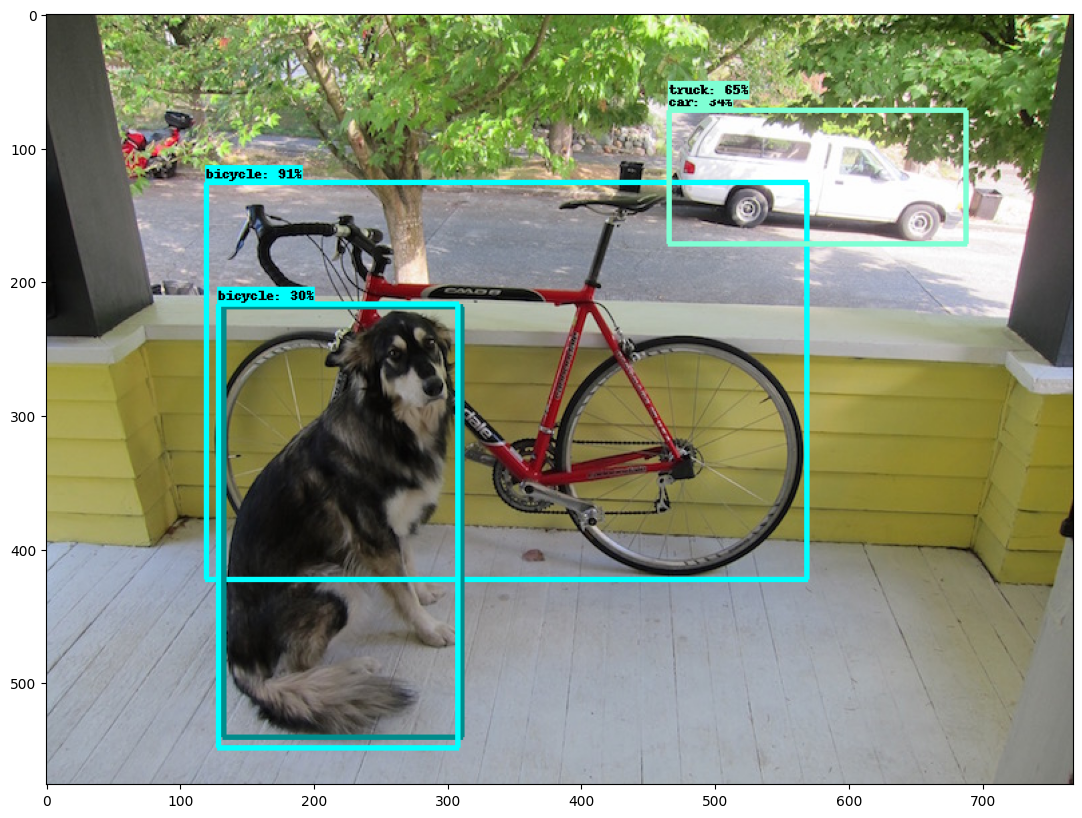

In [17]:
detect_objects('/kaggle/input/data-for-yolo-v3-kernel/dog.jpg')

Running inference for /kaggle/input/data-for-yolo-v3-kernel/office.jpg... Done


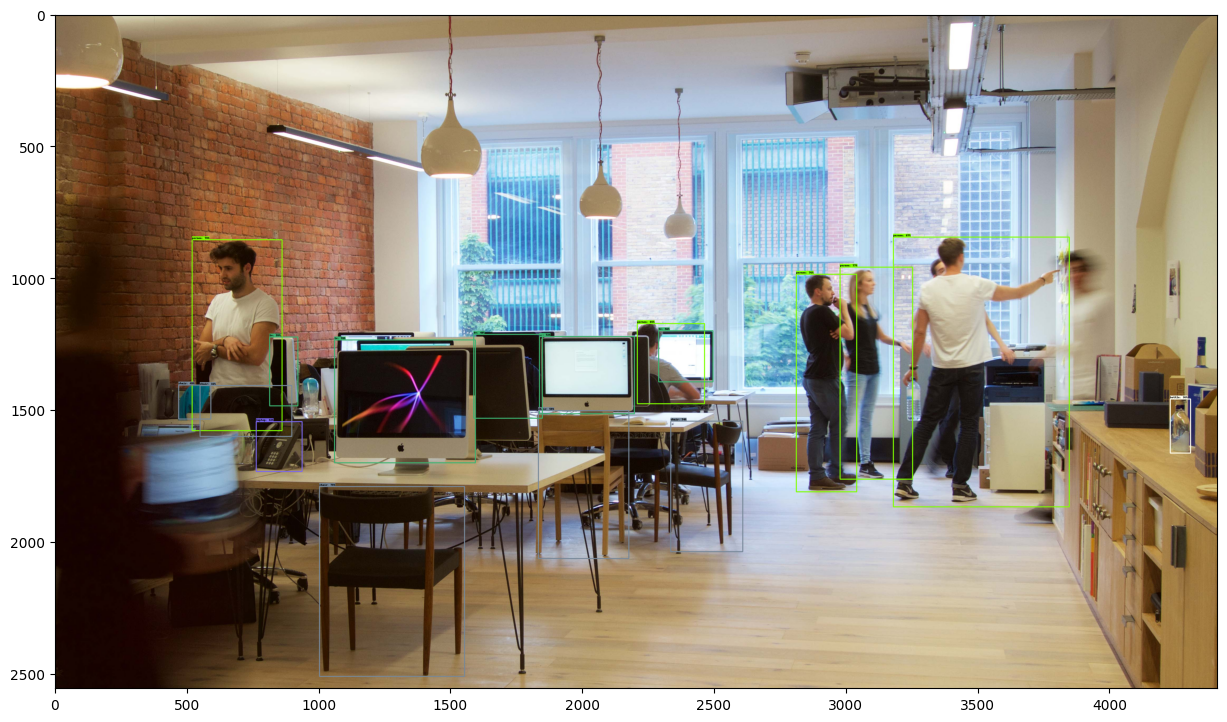

In [18]:
detect_objects('/kaggle/input/data-for-yolo-v3-kernel/office.jpg')